In [28]:
%matplotlib inline
import csv
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook, tqdm

from sklearn.metrics.pairwise import cosine_similarity

Dans ce notebook, j'utilise des embeddings pré-entrainés pour être capable de faire de l'analyse du langage. Ils peuvent être téléchargés ici : https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec.

`EMBEDDING_FILE_PATH` doit pointer vers l'endroit où se trouve les embeddings sur votre machine.

In [29]:
EMBEDDING_FILEPATH = 'wiki.fr.vec'
WORD_EMBEDDING_SIZE = 300
FILE_NAME = 'proposals_cleaned/fiscalite.json'

Chargement des word embeddings déjà entrainés.

In [30]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILEPATH, binary=False)

On itère sur les différentes contributions.
Pour chaque contribution, on crée un objet contenant le titre de la contribution et les réponses pour chaque question.

In [34]:
answer_frequency = defaultdict(lambda: 0)
questions = dict()
participations = []

In [35]:
with open(FILE_NAME, 'r') as input_file:
    for k in range(10000):
        responses = []
        line = next(input_file)
        participation = json.loads(line)
        assert(len(participation['responses']) == 8)
        responses.append(participation['titre'])

        for response in participation['responses']:
            
            if response['question']["id"] not in questions:
                questions[response['question']["id"]] = response['question']['title']
            if response['value']:
                answer_frequency[response['question']['title']] += 1
                # Try/except pour ne pas inclure les 'labels' et 'other' des QCM
                try:
                    text = json.loads((response["value"]))["other"]
                    responses.append(text)
                except:
                    responses.append(response['value'])
            responses.append(None)
        
        participations.append(responses)

Ici, on construit l'embedding d'une participation.

On construit l'embedding d'une participation comme la moyenne des embeddings de chaque réponse non nulle de la participation (le titre, la réponse à la première question, la réponse à la deuxième question, etc).

On construit l'embedding de chaque réponse comme la moyenne des embeddings de chaque mot reconnu de la réponse.

In [37]:
embeddings = np.zeros((len(participations), WORD_EMBEDDING_SIZE))
mots_inconnus = defaultdict(lambda: 0)
i = 0
for participation in participations:
    participation_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))
    number_of_responses = 0

    for response in participation:
        if response:
            number_of_responses += 1

            words = keras.preprocessing.text.text_to_word_sequence(
                response,
                filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                lower=True,
                split=' '
            )

            sentence_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))

            for word in words:
                try:
                    sentence_embedding += pretrained_embeddings[word.lower()]
                except:
                    mots_inconnus[word] += 1

            sentence_embedding /= max(len(words), 1)

            participation_embedding += sentence_embedding

    embeddings[i,:] = participation_embedding / max(1, number_of_responses)
    i += 1

In [38]:
embeddings.shape

(10000, 300)

On fait une PCA en dimension 3 pour voir s'il existe des clusters évidents.

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

pca = PCA(n_components=3)
print(pca.explained_variance_ratio_.cumsum())
tsne = TSNE(n_components=3)
principalComponents = pca.fit_transform(embeddings)
#tsne_embedding = tsne.fit_transform(embeddings) #Dure ~ 20min

principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2', 'principal component 3']
).values

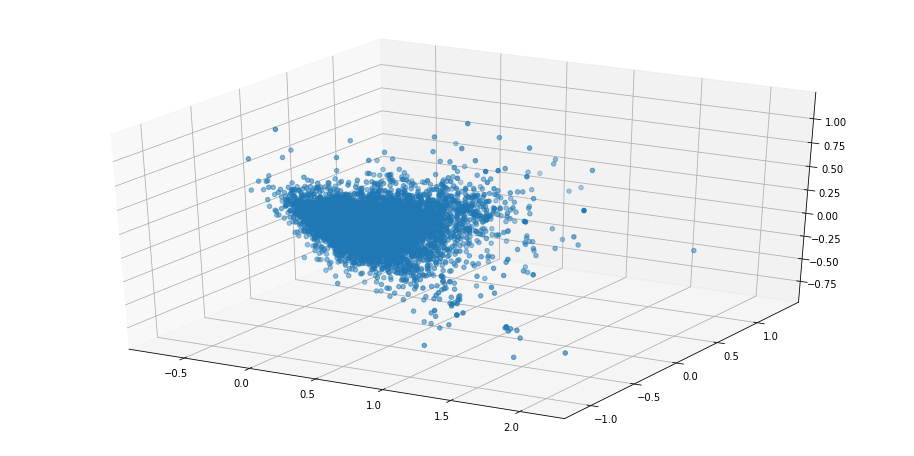

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalDf[:,0], principalDf[:,1], principalDf[:,2])

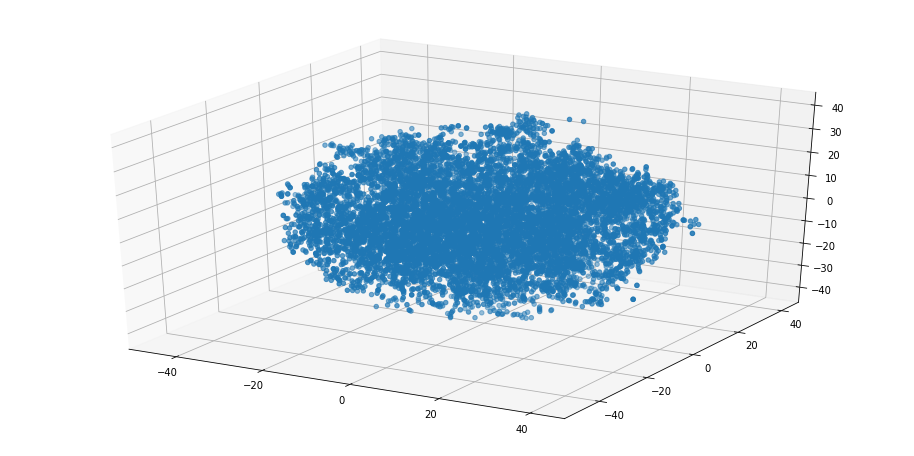

In [49]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_embedding[:,0], tsne_embedding[:,1], tsne_embedding[:,2])

In [53]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)
tsne = TSNE(n_components=2,verbose=1)
tsne_embedding_2d = tsne.fit_transform(embeddings)

principalDf = pd.DataFrame(
    data=principal_components,
    columns=['principal component 1', 'principal component 2']
).values

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.133s...
[t-SNE] Computed neighbors for 10000 samples in 58.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.130107
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.359406
[t-SNE] Error after 1000 iterations: 2.835620


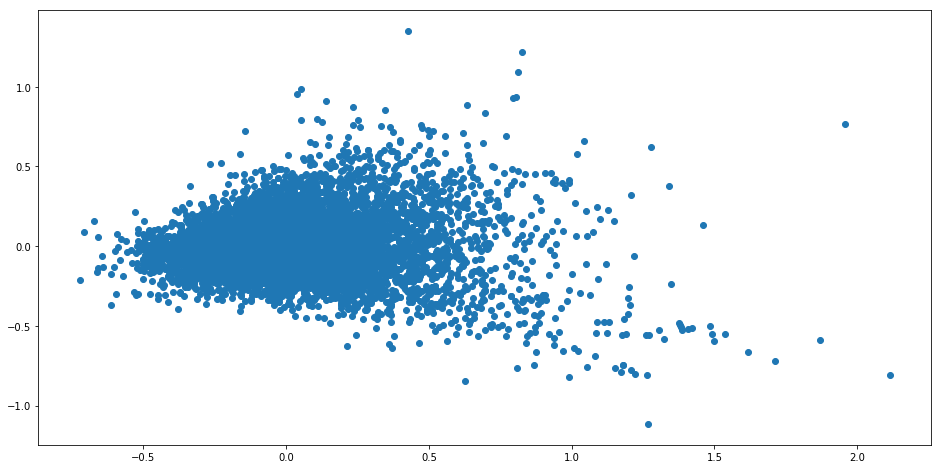

In [73]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.scatter(principalDf[:,0], principalDf[:,1])

/Users/Hippolyte/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 9999 + 1) instead
  app.launch_new_instance()


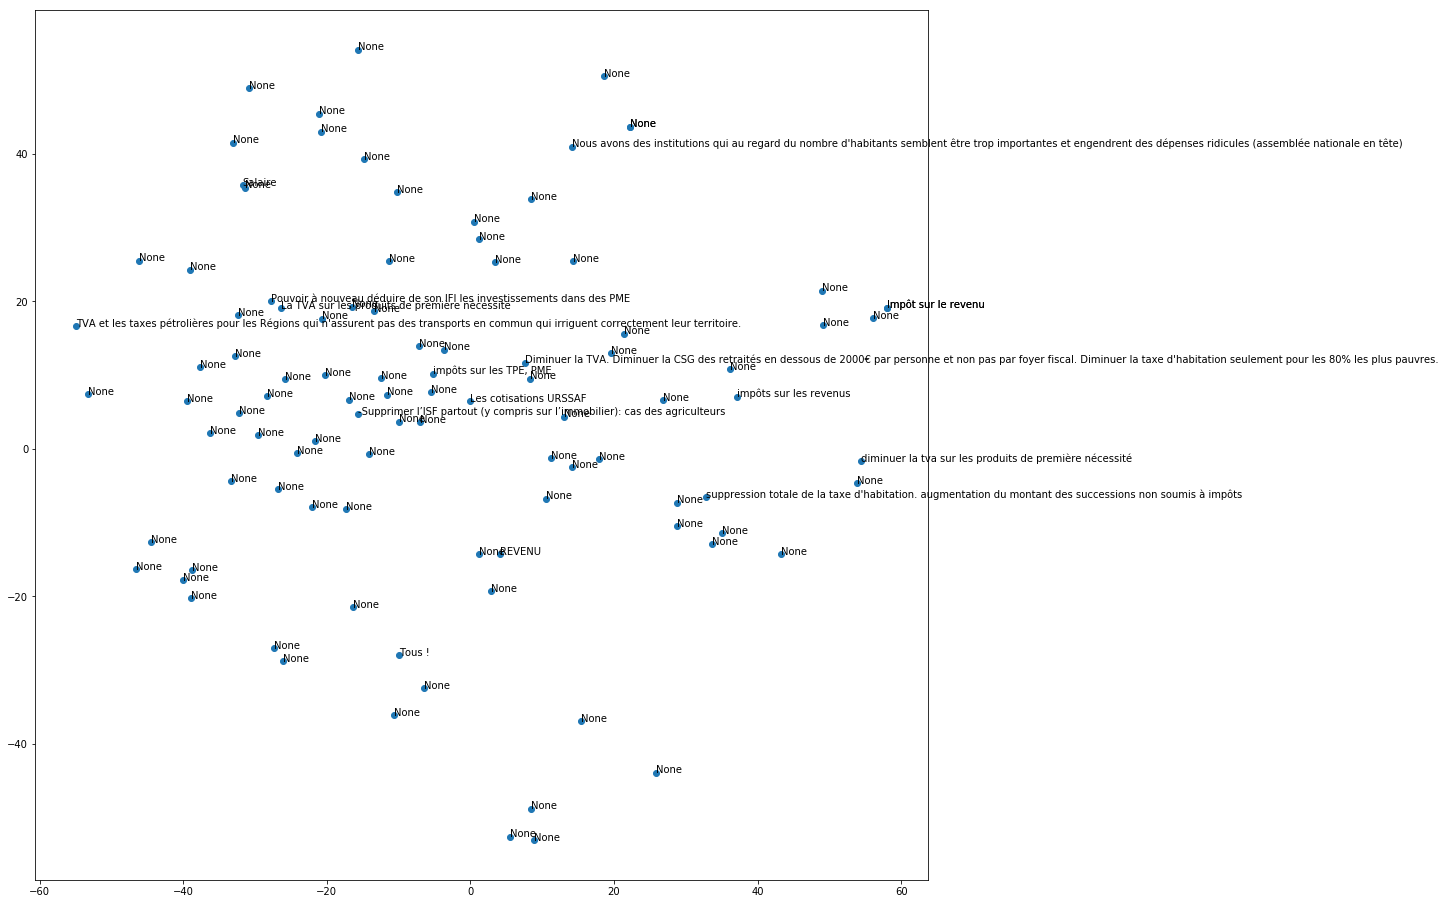

In [72]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
indices = np.random.random_integers(tsne_embedding_2d.shape[0]-1,size=100)
ax.scatter(tsne_embedding_2d[indices,0],tsne_embedding_2d[indices,1])
for i in indices:
    ax.text(tsne_embedding_2d[i,0],tsne_embedding_2d[i,1],participations[i][4])

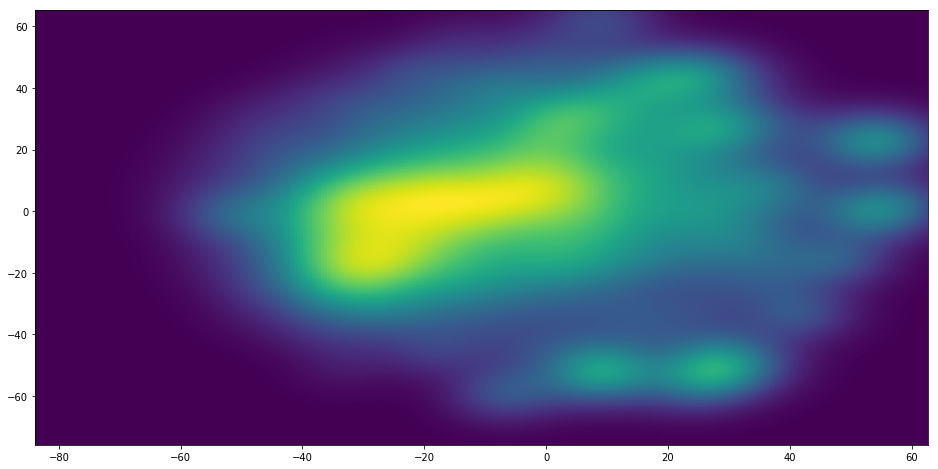

In [56]:
from scipy.stats import kde

nbins=300
#x, y = principalDf[:,0], principalDf[:,1]
x, y = tsne_embedding_2d[:,0], tsne_embedding_2d[:,1]
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Make the plot
fig = plt.figure(figsize=(16, 8))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()